## Семинар 8: "Снижение размерности"

ФИО: Дегтярев Роман Олегович

In [73]:
import numpy as np
from sklearn.datasets import fetch_olivetti_faces
from sklearn.cross_validation import train_test_split
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.autograd import Variable
import sys
from torch import optim
%matplotlib inline

Этот семинар посвящен снижению размерности на примере данных Olivetti faces. В данных содержатся 400 черно-белых изображений 64x64. Требуется исследовать различные способы снижения размерности: PCA и Автокодировщик

In [2]:
X = fetch_olivetti_faces()['data']

downloading Olivetti faces from http://cs.nyu.edu/~roweis/data/olivettifaces.mat to /Users/romandegtyarev/scikit_learn_data


In [3]:
from sklearn.decomposition import PCA

In [5]:
X.shape

(400, 4096)

In [4]:
model = PCA(n_components=25)
model.fit(X)

PCA(copy=True, iterated_power='auto', n_components=25, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [8]:
principle_components = model.components_

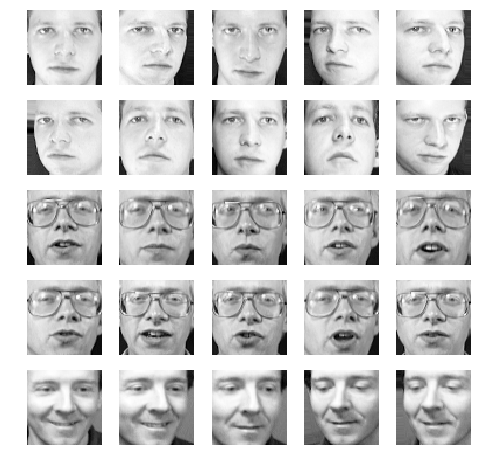

In [6]:
plt.figure(figsize=(8, 8))
for i in xrange(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(X[i].reshape(64, 64), cmap=plt.cm.Greys_r)
    plt.axis('off')
plt.show()

### Часть 1: PCA

In [10]:
from sklearn.decomposition import PCA

<i> 1.1 Примените алгоритм PCA к данным и отобразите главные компоненты. В качестве числа компонент выберите 25</i>

Подсказка: используйте метод <b>.components_</b>

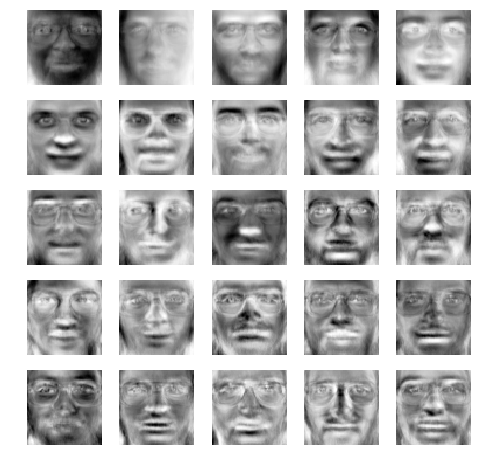

In [10]:
plt.figure(figsize=(8, 8))
for i in xrange(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(principle_components[i].reshape(64, 64), cmap=plt.cm.Greys_r)
    plt.axis('off')
plt.show()

<i> 1.2 Отобразите зависимость качества восстановления от количества компонент</i>

Подсказка: используйте методы <b>.transform</b> и <b>.inverse_transform</b>

In [15]:
#xrange - итератор, в памяти ничего не сохраняется
#range(список)

In [ ]:
embeding = model.transform(X)
recorstruction = model.inverse_transform(embeding)
recorstruction.shape, embeding.shape
((recorstruction - X)**2).sum()

In [16]:
#все компоненты уже подсчитаны

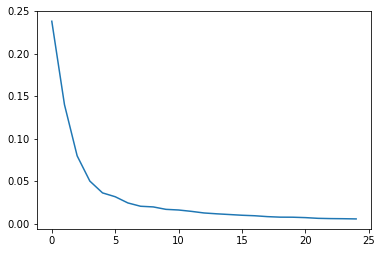

In [21]:
plt.plot(model.explained_variance_ratio_)

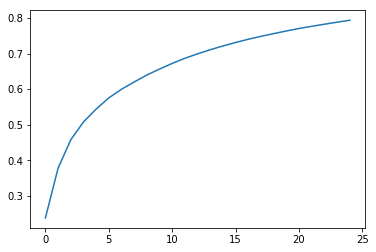

In [18]:
plt.plot(np.cumsum(model.explained_variance_ratio_))
#на дивергенция на диагонали в ковариационной матрице - это ошибки


In [23]:
#Посмотрим для всех компонент
model = PCA()
model.fit(X)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

ValueError: cannot reshape array of size 800 into shape (64,64)

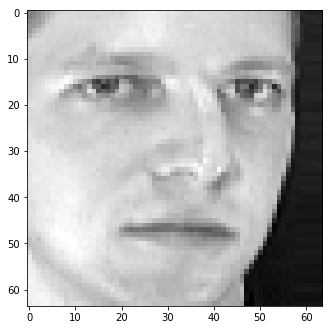

In [49]:
#нарисовать три графика: до, после и ошибка
plt.figure(figsize=(18,6))
plt.subplot(1,3,1)
plt.imshow((X)[1].reshape(64,64), cmap='gray')
plt.imshow((embeding).reshape(64,64), cmap='gray')



<i>1.3 Какое количество компонент следует выбирать, чтобы соблюсти баланс размерность — качество?</i>

In [29]:
#Вывод:100 компонент -самое оптимальное

<i>1.4 Отобразите данные на плоскости (количество компонент = 2). Выделились ли какие-нибудь кластеры? Если да, чему они соответствуют?</i>

In [35]:
model = PCA(n_components=2)
model.fit(X)
embeding = model.transform(X)
#plt.imshow(embeding[0])

In [44]:
def plot_dataset(X, emb, margin=50, frame=2000., imsize=64):
    assert(emb.shape[1] == 2)
    emb = np.array((emb - emb.min(0)) * (frame / (emb.max(0) - emb.min(0))) + margin, dtype = np.int)
    image = np.zeros((int(emb[:, 0].max() + margin + imsize), int(emb[:, 1].max() + margin + imsize))) + 1
    for k in xrange(X.shape[0]):
        image[emb[k, 0]:emb[k, 0]+64, emb[k, 1]:emb[k, 1]+64] = X[k].reshape(64, 64)
    plt.figure(figsize=(20, 20))
    plt.imshow(image, cmap="Greys_r")
    plt.axis("off")
    plt.show()

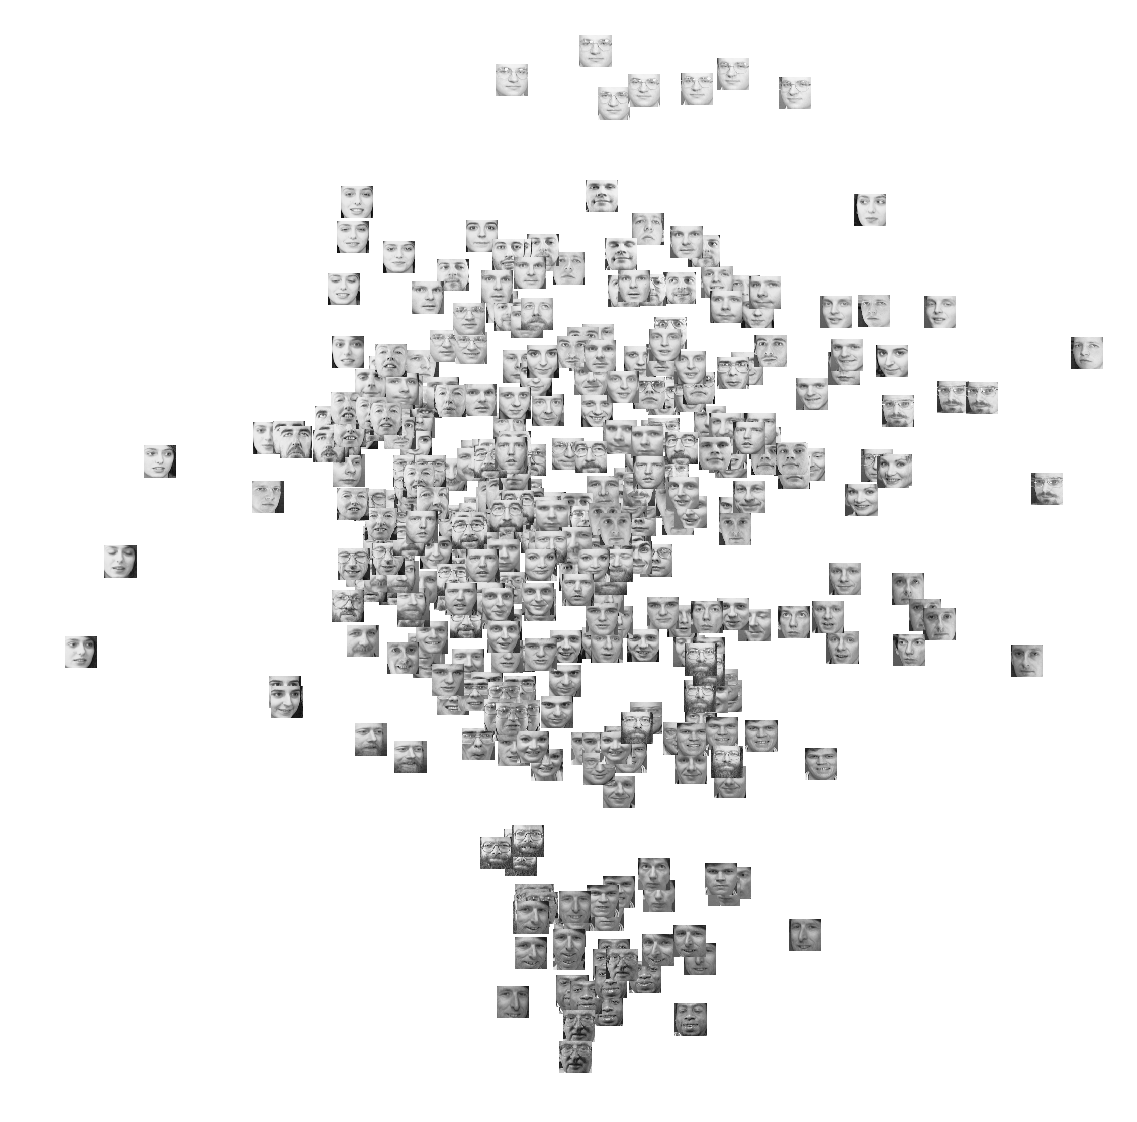

In [45]:
plot_dataset(X, embeding)

In [48]:
#первая компонента отвечает за свет
#вторая - отвечает за в то, в какаую сторону смотрит человек

###  Часть 2: Автокодировщик

<i> 2.1 Обучите автокодировщик с архитектурой 4096 -> 200 -> 10 -> 200 -> 4096. В качестве нелинейностей используйте сигмоиду.</i>

In [50]:
from torch.utils.data import DataLoader, Dataset

In [51]:
class FacesDataset(Dataset):
    def __init__(self, X):
        self.X = X
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return X[idx]

In [52]:
dataset = FacesDataset(X)
dataloader = DataLoader(dataset, batch_size=16, shuffle = True)

In [77]:
def fully_connected(arc, last_nonlinearity=True):
    layers = []
    for i in range(len(arc)-1):
        layers.append(nn.Linear(arc[i], arc[i+1]))
        if i != len(arc)-2 or last_nonlinearity:
            layers.append(nn.LeakyReLU())
    return nn.Sequential(*layers)

In [78]:
fully_connected([4096, 200, 10], last_nonlinearity=False)

Sequential (
  (0): Linear (4096 -> 200)
  (1): LeakyReLU (0.01)
  (2): Linear (200 -> 10)
)

In [79]:
class AE(nn.Module):
    def __init__(self, arc_encoder, arc_decoder):
        super(AE, self).__init__()
        #create encoder
        
        self.encoder = fully_connected(arc_encoder)
        self.decoder = fully_connected(arc_decoder)
        
    def forward(self, X):
        return self.decoder(self.encoder(X))

In [80]:
model = AE([4096, 200, 10], [10,200,4096])

In [81]:
loss = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr = 0.001)

In [86]:
for epoch in xrange(10):
    losses =[]
    for x in dataloader:
        x_batch = Variable(x)
        y_batch = Variable(x, requires_grad = False)
        model.zero_grad()
        x_reconstruction = model(x_batch)
        loss_batch = loss(x_reconstruction, y_batch)
        loss_batch.backward()
        optimizer.step()
        losses.append(loss_batch.data[0])
    sys.stdout.write('\r {}'.format(np.mean(losses)))

 0.00653391325846

In [94]:
embedding = model.encoder(Variable(torch.Tensor(X))).data.numpy()

In [95]:
reconstruction = model(Variable(torch.Tensor(X))).data.numpy()

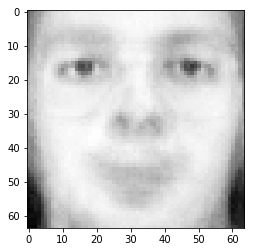

In [96]:
plt.imshow(reconstruction[0].reshape(64,64), cmap=plt.cm.Greys_r)

In [97]:
#У PCA можно аналитически найти embedding 
#У деколера стохастическим градиентом все происходит

<i> 2.2 Какое качество восстановления удалось получить?</i>

<i> 2.3 Обучите сеть с разными размерностями пространства, в которое происходит отображение </i>

<i> 2.4 Сравните графики из пунктов 1.2 и 2.3 </i>

<i> 2.5 Отобразите данные на плоскости (количество компонент = 2). Выделились ли какие-нибудь кластеры? Если да, чему они соответствуют?</i>

#### Feedback (опционально)

Здесь вы можете оставить список опечаток из лекции или семинара:

Здесь вы можете оставить комментарии по лекции или семинару: